```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Producing plots of data-assimilation and drift trajectory forecasting 
experiments by post-processing the files produced by 
scripts/run_experiment.py

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Post Processing of Data Assimilation experiments

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('text', usetex=True)


#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, ParticleInfo
from SWESimulators import DataAssimilationUtils as dautils

/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
%cuda_context_handler gpu_ctx
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")


## Specify the folder containing the results

NB - You should match the `result_dir` with the variable `main_title`

In [3]:
result_dir = os.path.abspath('/lustre/storeB/users/florianb/forecasting_results/da_experiment_2021_10_05-13_38_41-none')

print("results from ", result_dir)

#main_title = "No data assimilation"
#main_title = "Ten drifters"
#main_title = "All drifters"
main_title = "All moorings"
#main_title = "West moorings"
#main_title = "South moorings"

truth_folder = os.path.join(result_dir, "truth")

savefigs = True

assert(os.path.isdir(result_dir)), "Directory which is supposed to contain the results does not exist"

results from  /lustre/storeB/users/florianb/forecasting_results/da_experiment_2021_10_05-13_38_41-none


In [4]:
def file_filter(path_to_dir, ext=None, prefix=None, abspath=True):
    filtered_files = os.listdir(path_to_dir)
    if prefix:
        filtered_files = list(file for file in filtered_files if file.startswith(prefix))
    if ext:
        filtered_files = list(file for file in filtered_files if file.endswith(ext))
    if abspath:
        filtered_files= list(os.path.join(path_to_dir, file)  for file in filtered_files)

    filtered_files.sort()
    return filtered_files


nc_files = file_filter(result_dir, ext='nc')
obs_files = file_filter(result_dir, ext='bz2', prefix='forecast')
particle_info_files = file_filter(result_dir, ext='bz2', prefix='particle_info')


print("number of nc_files:            ", len(nc_files))
print("number of obs_files:           ", len(obs_files))
print("number of particle_info_files: ", len(particle_info_files))

# Truth:
true_nc = truth_folder + "/double_jet_case_truth.nc"
true_obs_file = truth_folder + "/drifter_observations.pickle"
    
ensemble_size = 100


number of nc_files:             100
number of obs_files:            99
number of particle_info_files:  700


In [5]:
# Read netCDF files
reload(SimReader)

truth_reader = SimReader.SimNetCDFReader(true_nc)
sim_readers = [None]*ensemble_size
for particle_id in range(ensemble_size):
    if particle_id != 63:
        sim_readers[particle_id] = SimReader.SimNetCDFReader(nc_files[particle_id])



### Functions for plotting

In [19]:
def _markDriftersInImshow(ax, observed_drifter_positions):

    dx, dy = truth_reader.get('dx'), truth_reader.get('dy')
    for d in range(observed_drifter_positions.shape[0]):
        cell_id_x = int(np.floor(observed_drifter_positions[d,0]/dx))
        cell_id_y = int(np.floor(observed_drifter_positions[d,1]/dy))
        circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 2, fill=False)
        ax.add_patch(circ)

def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), # (12.5, 3.4)
            color_bar_from_zero=False, save_filename=None, constant_range=False, pretitle='',
            mark_drifter_positions = None):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    #fig = plt.figure(figsize=figsize)

    #gs = fig.add_gridspec(1,10)#, sharey=True)
    #axs = [None, None, None]
    #axs[0] = fig.add_subplot(gs[0, 1:4])
    #axs[1] = fig.add_subplot(gs[0, 4:7])
    #axs[2] = fig.add_subplot(gs[0, 7:10])
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 0.005
        huv_max = 5
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        if constant_range:
            eta_max = 0.025 #0.12
            huv_max = 7.5 #50
        
        eta_cmap = 'BuGn'
        huv_cmap = 'Blues'
        
    nx = truth_reader.get('nx')
    ny = truth_reader.get('ny')
    dx = truth_reader.get('dx')
    dy = truth_reader.get('dy')
    extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
    
    
    fontsize = 18
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, pretitle+"$\eta$ [m]")
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[1], hu_im, pretitle+"$hu$ [m$^2$/s]")
    
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent, cmap=huv_cmap)
    addColorbar(axs[2], hv_im, pretitle+"$hv$ [m$^2$/s]")
    
    axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)

    if mark_drifter_positions is not None:
        dx, dy = truth_reader.get('dx'), truth_reader.get('dy')
        mark_drifter_positions[:,0] = mark_drifter_positions[:,0]*dx/1000
        mark_drifter_positions[:,1] = mark_drifter_positions[:,1]*dy/1000
        _markDriftersInImshow(axs[1], mark_drifter_positions)
        _markDriftersInImshow(axs[2], mark_drifter_positions)
    
    #for ax in axs:
    #    ax.set_xlabel("$x$ [km]")
    #    ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    #plt.tight_layout()
    
    if save_filename is not None and savefigs:
        fig.savefig(result_dir + "/" + save_filename + ".png", bbox_inches='tight')
        fig.savefig(result_dir + "/" + save_filename + ".pdf", bbox_inches='tight')
        
        
    
def days_to_sec(days):
    return days*24*60*60

def sec_to_days(secs):
    return secs/(24*60*60)

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

In [7]:
## Quiver plot for day 10
def make_quiver(hu, hv, eta, save_filename=None):
    H = truth_reader.getH().max()
    day =10
    #print(dx, dy)

    u = hu/(H + eta)
    v = hv/(H + eta)

    dx, dy = truth_reader.get('dx'), truth_reader.get('dy')

    velocity = np.sqrt(u*u + v*v)

    #print(u.shape)
    frequency_x = 20
    frequency_y = 20
    x = np.arange(0, 500, frequency_x)*dx/1000
    y = np.arange(0, 300, frequency_y)*dy/1000
    u = u[::frequency_y, ::frequency_x]
    v = v[::frequency_y, ::frequency_x]
    #print(u.shape)

    velocity_quiver = velocity[::frequency_y, ::frequency_x]

    #plt.quiver(x, y, u, v, velocity_quiver)

    fig = plt.figure(figsize=(5,3))
    ax = plt.subplot(111)
    im = ax.imshow(velocity, cmap=plt.cm.Oranges, extent=[0, x[-1], 0, y[-1]], origin='lower', vmax=3, vmin=0)
    quiv = ax.quiver(x, y, u, v)
    ax.set_title('Mean ocean currents [m/s] day '+str(day), fontsize=15)
    plt.suptitle(r"\textbf{"+main_title+"}", y=1.1) #, fontsize=14)

    cb = plt.colorbar(im)
    
    if save_filename is not None and savefigs:
        fig.savefig(save_filename + ".png", bbox_inches='tight')
        fig.savefig(save_filename + ".pdf", bbox_inches='tight')
    

# Mean and variance for different timesteps

In [8]:
# Printing the timestamps for particle zero:
example_sim_reader = sim_readers[0]
times = example_sim_reader.getTimes()
print(sec_to_days(times.data))
print('Hopefully these values are only full days')


[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
Hopefully these values are only full days


In [9]:
time0 = days_to_sec(4.0)

In [10]:
from SWESimulators import Common
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import EnsembleFromFiles

In [11]:
gpu_ctx = Common.CUDAContext()
observation_type = dautils.ObservationType.StaticBuoys

In [12]:
ensemble = EnsembleFromFiles.EnsembleFromFiles(gpu_ctx, 
                                                100,                                                
                                                result_dir, 
                                                truth_folder,                                                
                                                1.0,
                                                cont_write_netcdf = False,
                                                use_lcg = True,
                                                write_netcdf_directory = result_dir,
                                                observation_type = observation_type,
                                                time0=time0)


In [13]:
from SWESimulators import IEWPFOcean
import ETKFOcean

In [14]:
iewpf = IEWPFOcean.IEWPFOcean(ensemble)
etkf  = ETKFOcean.ETKFOcean(ensemble)

In [15]:
obstime = time0

for minute in range(5):
    obstime += 60
    ensemble.stepToObservation(obstime, model_error_final_step=(minute<4))
    
    if minute == 4:
        eta, hu, hv = ensemble.particles[0].download()
        ensemble_backup = ensemble
        # IEWPF #################################################
        etaDeterm, huDeterm, hvDeterm = iewpf.iewpf_2stage(ensemble, perform_step=False)
        etaFull, huFull, hvFull = ensemble.particles[0].download()



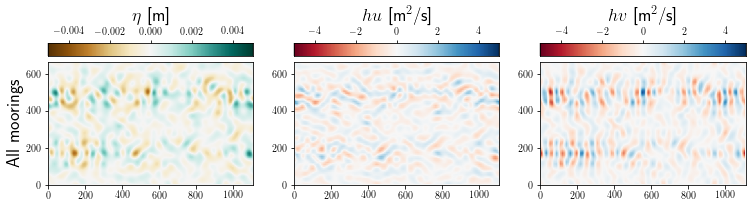

In [21]:
imshow3(etaDeterm-eta,huDeterm-hu,hvDeterm-hv, constant_range=True)

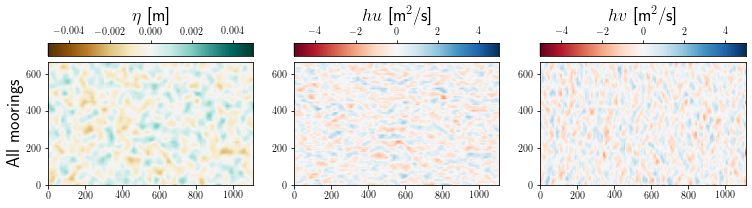

In [22]:
imshow3(etaFull-etaDeterm,huFull-huDeterm,hvFull-hvDeterm, constant_range=True)

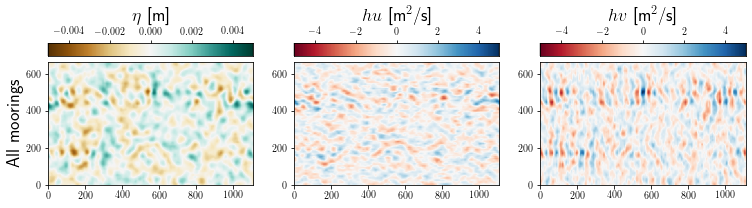

In [23]:
imshow3(etaFull-eta,huFull-hu,hvFull-hv, constant_range=True)